In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math 
import sklearn.preprocessing 
import random
import yaml
import h5py
import logging
import datetime
import os
import time
import sys

import pprint
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SequentialSampler, BatchSampler
import torch.nn.functional as F


from load_matlab_timedata import get_data_from
from src.TSGenerator import f_Y, f_X, get_func_timeseries
from src.DataLoader import TimeSeriesDataset
from src.model_utils import init_logger, plot_shared_scale, plot_multiscale
from src.Model import LSTM
from src.Losses import myLoss, aux_loss_jordan, prognose_dy

from torch.optim.lr_scheduler import ReduceLROnPlateau  


## Loading config files, setup execution parameters, init objects

In [2]:
plt.rcParams['figure.figsize'] = 20, 7.
CONFIG_FILENAME = "model_params_jordan.yaml"
# ! ls DC_motor_simulation
with open(CONFIG_FILENAME, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
   
pprint.pprint(config)


p_net = config['network_params']

p_train = config['train_params']

p_gen = config['generator_params']

p_data = config['data_params']
need_normalize = p_data['need_normalize']

{'data_params': {'best_discrete_k': 3,
                 'integration_step': 0.01,
                 'leave_nth': 13,
                 'mat_file': 'DC_motor_simulation/train_3_parameters.mat',
                 'need_normalize': True,
                 'specific_data_source': 'DC_motor_simulation/test_3_parameters_d_001_2.mat',
                 'specific_data_sources': {'dur': 'DC_motor_simulation/test_3_parameters_d_001_2.mat',
                                           'noice': 'DC_motor_simulation/test_3_parameters_5_15_1_20_additive_noise.mat',
                                           'range': 'DC_motor_simulation/test_3_parameters_v_0_33.mat',
                                           'sin': 'DC_motor_simulation/test_3_parameters_5_15_1_20_additive_sin.mat'},
                 'test_size': 0.3,
                 'tested_models': ['jordan_indep_estimate_1l 2h '
                                   '1b_18_May_11_42PM.pt',
                                   'jordan_full_blind_lower_cp_002

# Set parameters

In [3]:

# # If `per_element` is True, then LSTM reads in one timestep at a time.
if  p_net['per_element']:
    lstm_input_size = 1
else:
    lstm_input_size = p_net['input_size']
    
# if is_debug:
#     x, y = get_func_timeseries(f_Y = f_Y, f_X = f_X, a=p_generate['a'], b=p_generate['b'])
to_generate_data = config['to_generate_data'] 
if to_generate_data:
    p_gen = config['generator_params']
    print("Data generator params:")
    pprint.pprint(p_gen)
    a = p_gen['a']
    b = p_gen['b']
is_debug = config['is_debug']


init_logger(config)

logging.info("Experiment started with params")
logging.info(f"data_par: {p_data}")
logging.info(f"net_par: {p_net}")
logging.info(f"train_par: {p_train}") 

logger inited to file [only_batcheslogs/exp_2019-05-19_01:02:26.log]


## Init data loader and get appropriate part of data

## Creating objects from imported files

In [4]:
from src.Model import LSTM, LSTM_jordan
from src.Losses import myLoss, prognose_dy, myLoss_jordan  # imports here for faster rerun and debug procedure

model = LSTM_jordan(lstm_input_size,
             p_net['hidden_size'],
             batch_size=p_train['batch_size'],
            jordan_params=3,
             output_dim=1,
             num_layers=p_net['num_layers'],
                    lstm_bias=p_net['bias'])

loss_fn = myLoss_jordan


In [5]:
for name, parameter in model.named_parameters():
    print(name, '\t\t', parameter.shape)

jordan 		 torch.Size([1, 3])
lstm.weight_ih_l0 		 torch.Size([8, 4])
lstm.weight_hh_l0 		 torch.Size([8, 2])
lstm.bias_ih_l0 		 torch.Size([8])
lstm.bias_hh_l0 		 torch.Size([8])
linear.weight 		 torch.Size([1, 2])
linear.bias 		 torch.Size([1])


In [6]:
model.lstm.parameters

<bound method Module.parameters of LSTM(4, 2)>

In [7]:
model.jordan.requires_grad

True

In [8]:
p_optim = p_train['optimizer']

if p_optim['optimizer'] == "adam":
    optimizer = torch.optim.Adam(
#         filter(lambda p: p.requires_grad, model.parameters()),
#         lr=0.01
        [
                {
                    'params': filter(lambda p: p.requires_grad, [model.jordan]),
                    'lr': 0,
                    'betas': (0.8, 0.95),
                    'weight_decay':p_optim['jordan']['wd']
                },
                {
                    'params': filter(lambda p: p.requires_grad, model.lstm.parameters()), 
                    'lr': p_optim['lstm']['lr'],
                    'weight_decay':p_optim['lstm']['wd']
                },
                {
                    'params': filter(lambda p: p.requires_grad, model.linear.parameters()),
                    'lr': p_optim['linear']['lr'],
                    'weight_decay':p_optim['linear']['wd']
                }
            ]
    )

logging.info(f"Model n params: {model.get_num_params()}")
print(f"model has [{model.get_num_params()}] params")
num_epochs = p_train['num_epochs']
logging.info("Training process INITIALIZED")
optimizer

model has [70.0] params


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.8, 0.95)
    eps: 1e-08
    lr: 0
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [9]:
optim_jord = torch.optim.Adam(
        [
                {
                    'params': filter(lambda p: p.requires_grad, [model.jordan]),
                    'lr': p_optim['jordan']['lr'],
                    'betas': (0.8, 0.95),
                    'weight_decay':p_optim['jordan']['wd']
                },
                {
                    'params': filter(lambda p: p.requires_grad, model.lstm.parameters()), 
                    'lr': p_optim['lstm']['lr'],
                    'weight_decay':p_optim['lstm']['wd']
                },
                {
                    'params': filter(lambda p: p.requires_grad, model.linear.parameters()),
                    'lr': p_optim['linear']['lr'],
                    'weight_decay':p_optim['linear']['wd']
                }
            ]
    )

In [10]:
p_sched = p_train['lr_scheduler']
scheduler = ReduceLROnPlateau(optimizer=optimizer,
                              mode='min',
                              factor=p_sched['lr_drop'],
                              patience=p_sched['patience'],
                              cooldown=p_sched['cooldown'],
                              threshold=p_sched['threshold'],
                              threshold_mode='rel',
                              min_lr=10**p_sched['early_stop_order'],
                             verbose=True
                             )
print("LR scheduler set_uped")
scheduler.state_dict()

LR scheduler set_uped


{'factor': 0.4,
 'min_lrs': [1e-08, 1e-08, 1e-08],
 'patience': 60,
 'verbose': True,
 'cooldown': 4,
 'cooldown_counter': 0,
 'mode': 'min',
 'threshold': 0.01,
 'threshold_mode': 'rel',
 'best': inf,
 'num_bad_epochs': 0,
 'mode_worse': inf,
 'eps': 1e-08,
 'last_epoch': -1}

In [11]:
sample_x= torch.rand([p_net['retrospective_steps'], p_train['batch_size'], 1])
y, pars = model(sample_x)

In [12]:
sample_x.shape


torch.Size([64, 1024, 1])

using 1.0 of data
loading from [DC_motor_simulation/train_3_parameters.mat]
X normalized, norms: [14.99931682]
x shape (76924, 1)
x_normalized shape (76924, 1)


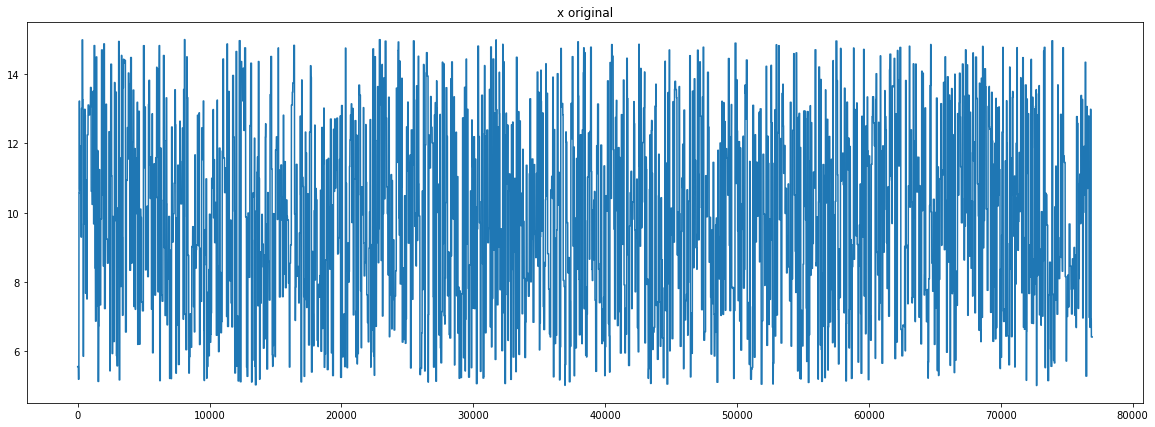

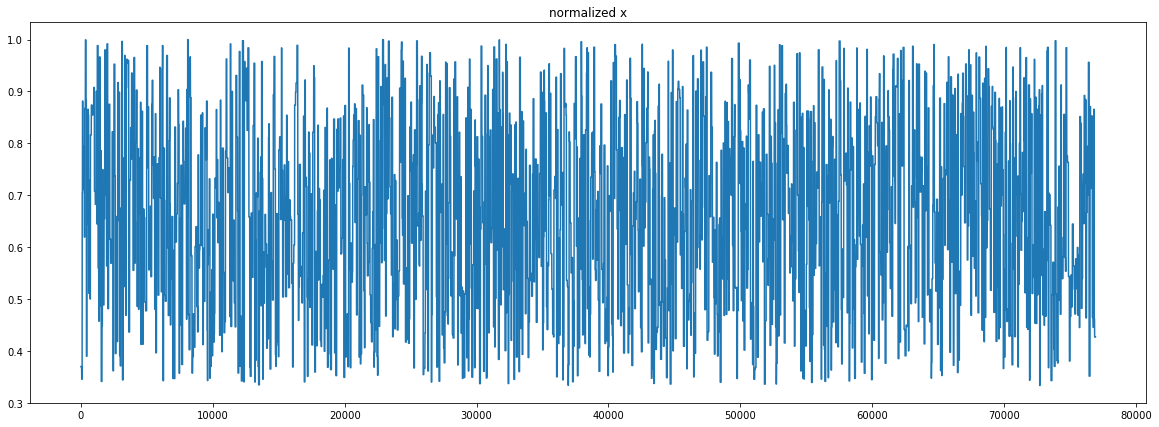

Y normalized, norms: [0.01324489]
input shape (76924, 1)
input partition shape (23078, 1)
output partition shape (23078, 1)
stacked Y shape  (23014, 1)
Y_tensor torch.Size([23014, 1])
X_tensor torch.Size([64, 23013, 1])
loading from [DC_motor_simulation/train_3_parameters.mat]
X normalized, norms: [14.99931682]
x shape (76924, 1)
x_normalized shape (76924, 1)


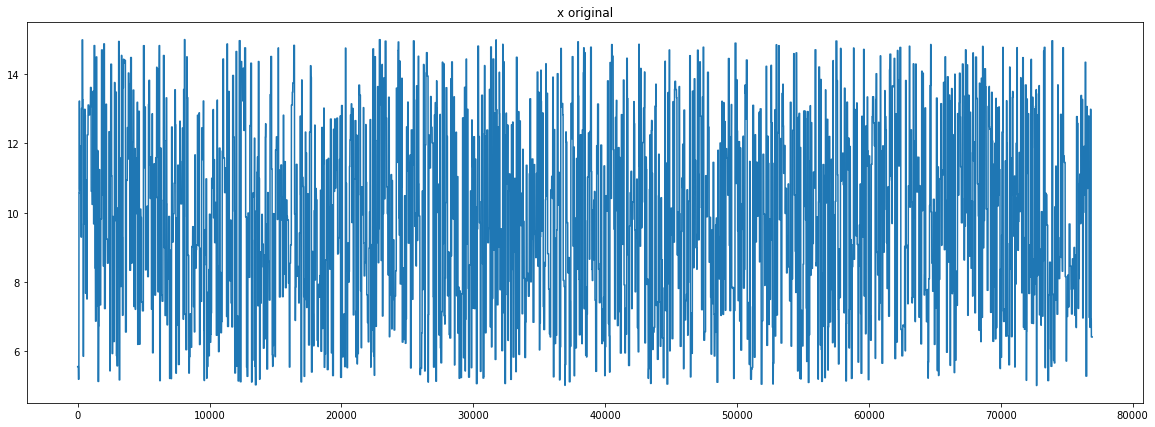

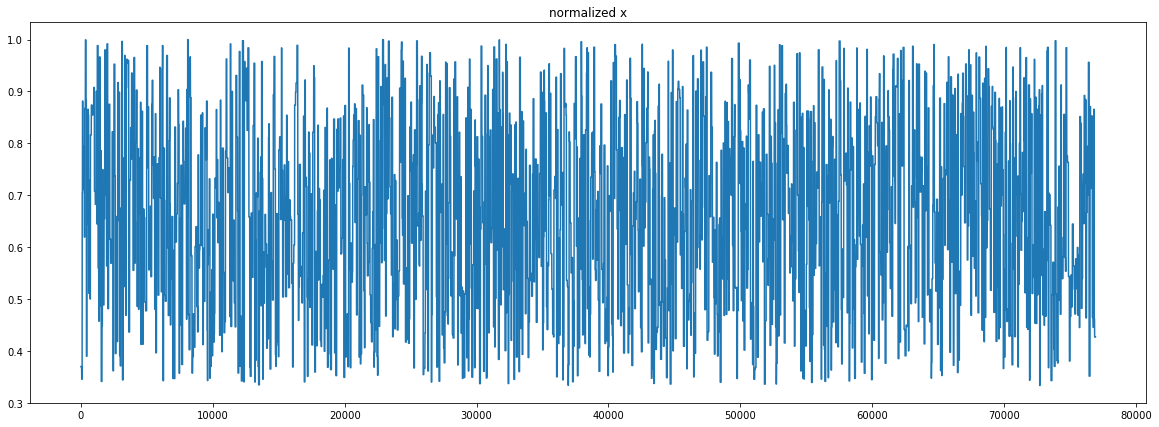

Y normalized, norms: [0.01324489]
input shape (76924, 1)
input partition shape (53846, 1)
output partition shape (53846, 1)
stacked Y shape  (53782, 1)
Y_tensor torch.Size([53782, 1])
X_tensor torch.Size([64, 53781, 1])
train set: [53782] batches
test set: [23014] batches
data_loading time 63.69095182418823 secs


In [13]:
# todo add time tracking for this cell
use_part = p_data['use_part_of_data']
print(f"using {use_part} of data")

t_tick = time.time()

test_ts_ds = TimeSeriesDataset(config=config,
                               partition=(use_part - use_part*p_data['test_size'], use_part),                        
                               logging=logging)

train_ts_ds = TimeSeriesDataset(config=config,
                                partition=(0, use_part - use_part*p_data['test_size']),
                                logging=logging)

print(f"train set: [{len(train_ts_ds)}] batches")
print(f"test set: [{len(test_ts_ds)}] batches")

if need_normalize:
    config['x_norm'] = train_ts_ds.x_norms[0]
    config['y_norm'] = train_ts_ds.y_norms[0]
    config['x_norm']
else:
    config['x_norm'] = 1
    config['y_norm'] = 1
    config['x_norm']

train_dl = DataLoader(dataset = train_ts_ds,
                      batch_sampler = BatchSampler(
                          sampler = SequentialSampler(train_ts_ds), 
                          batch_size = p_train['batch_size'],
                          drop_last = True)
                     )
test_dl = DataLoader(dataset = test_ts_ds,
                     batch_sampler = BatchSampler(
                     sampler = SequentialSampler(test_ts_ds), 
                     batch_size = p_train['batch_size'], 
                     drop_last = True)
                    )    
    
t_tock = time.time()
dataload_time = t_tock - t_tick
print(f"data_loading time {dataload_time} secs")

## Inspecting data we have, get several batches and look inside on pretty large scale to see individual iterations:

x [batch_size, retrospective_steps, channels] :torch.Size([1024, 64, 1])
y [batch_size, channels]: torch.Size([1024, 1])
y_last [slice_size]: (150,)


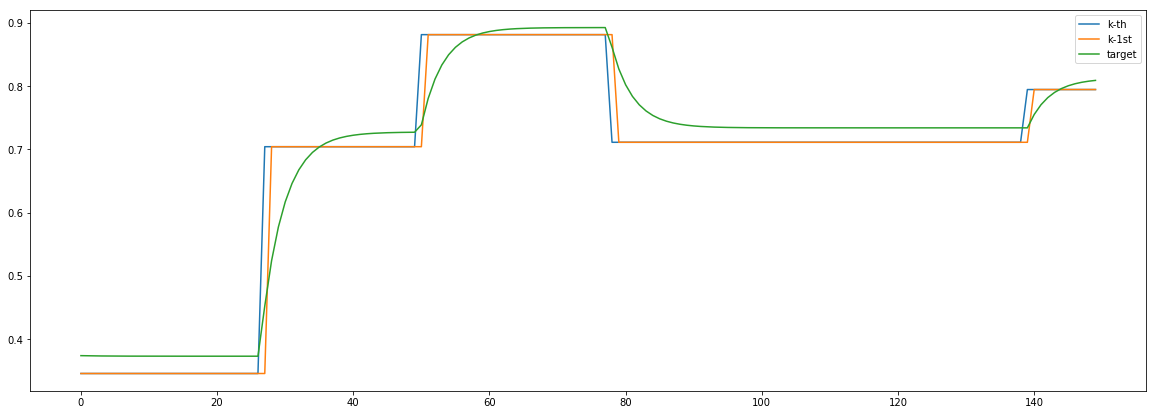

x [batch_size, retrospective_steps, channels] :torch.Size([1024, 64, 1])
y [batch_size, channels]: torch.Size([1024, 1])
y_last [slice_size]: (150,)


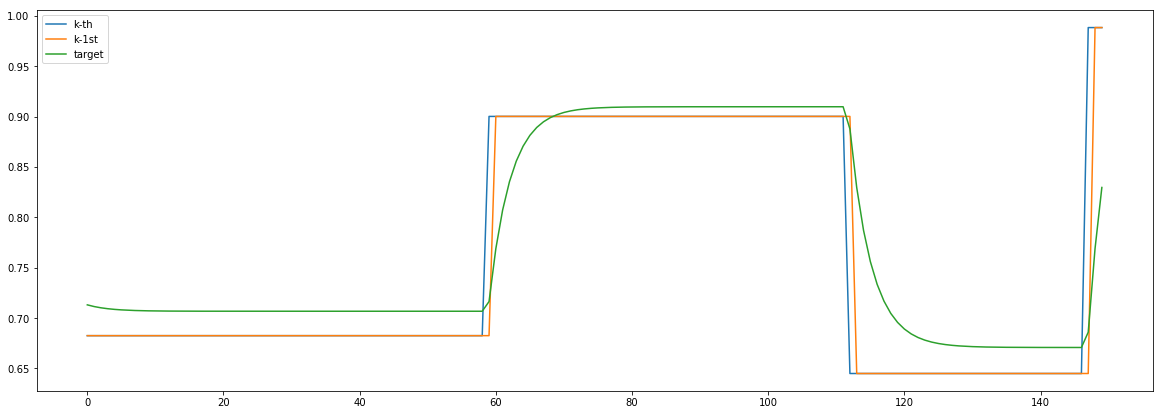

In [14]:
f, t = 0, 150
for i, batch in enumerate(train_dl):
    x, y, ind = batch
    print(f"x [batch_size, retrospective_steps, channels] :{x.shape}")
    print(f"y [batch_size, channels]: {y.shape}")
    y_kth = y.detach().numpy()[f:t, 0]
    print(f"y_last [slice_size]: {y_kth.shape}")
    x = x.transpose(0,1)
    plt.plot(x.detach().numpy()[-1][f:t], label='k-th')
    plt.plot(x.detach().numpy()[-2][f:t], label='k-1st')
    plt.plot(y_kth, label='target')
    plt.legend()
    plt.show()
    if i == 1:
        break

In [15]:
# #####################
# # 
# #####################
# from torch.nn import init
# for layer_p in a._all_weights:
#     for p in layer_p:
#         if 'weight' in p:
#             # print(p, a.__getattr__(p))
#             init.normal(a.__getattr__(p), 0.0, 0.02)

In [16]:
logging.info("History INITIALIZED")

hist = {
    
    "train":{
        "batches":{
            "main":np.zeros(len(train_dl)),
            "aux":np.zeros(len(train_dl)),
            "jordan":np.zeros(len(train_dl))
        },
        "epochs":{
            "main":np.zeros(num_epochs),
            "aux":np.zeros(num_epochs),
            "jordan":np.zeros(num_epochs)
        }
    },
    
    "eval_train":{
        "batches":{
            "main":np.zeros(len(train_dl)),
            "aux":np.zeros(len(train_dl)),
            "jordan":np.zeros(len(train_dl))
        },
        "epochs":{
            "main":np.zeros(num_epochs),
            "aux":np.zeros(num_epochs),
            "jordan":np.zeros(num_epochs)
        }
    },
    
    "eval_test":{
        "batches":{
            "main":np.zeros(len(test_dl)),
            "aux":np.zeros(len(test_dl)),
            "jordan":np.zeros(len(test_dl))
        },
        "epochs":{
            "main":np.zeros(num_epochs),
            "aux":np.zeros(num_epochs),
            "jordan":np.zeros(num_epochs)
        }
    },
    
    'mean_params_sample':
    {
        '1':np.zeros(num_epochs),
        '2':np.zeros(num_epochs),    
        '3':np.zeros(num_epochs)
    },
    'lr': np.zeros(num_epochs),
    'loss_rate': np.zeros(num_epochs),
    'weights_sum': np.zeros(num_epochs), 
    'weights_var': np.zeros(num_epochs),
    
    'grads':{
        'batches':{name: np.zeros(len(train_dl)) for name, parameter in model.named_parameters()},
        'epochs':{name: np.zeros(num_epochs) for name, parameter in model.named_parameters()}
    },
    'weights':{
        'batches':{name: np.zeros(len(train_dl)) for name, parameter in model.named_parameters()},
        'epochs':{name: np.zeros(num_epochs) for name, parameter in model.named_parameters()}
    },
    'vars':{
        'batches':{name: np.zeros(len(train_dl)) for name, parameter in model.named_parameters()},
        'epochs':{name: np.zeros(num_epochs) for name, parameter in model.named_parameters()}
    },
    'param_grads':{
        'batches':{"p1":np.zeros(len(train_dl)),
                   "p2":np.zeros(len(train_dl)),
                   "p3":np.zeros(len(train_dl))
                  },
        'epochs':{
            "p1":np.zeros(num_epochs), 
            "p2":np.zeros(num_epochs),
            "p3":np.zeros(num_epochs)
        }
    },
    'aux_global':[],
    'grad_global':{'p1':[], 'p2':[],'p3':[],'lstm':[], 'linear':[]}
}

In [17]:
def batch_iteration(iter_index, model, optimizer, batch_data, backprop, hist_part):
    
    x_batch, y_batch, indexes = batch_data
    x_batch.transpose_(0, 1) # todo get rid of it
    model.hidden = model.init_hidden()   
    
    
    if backprop:
        y_pred, jordan = model(x_batch)
        
        losses = loss_fn(y_pred, jordan.t(), y_batch, x_batch, config, 
                        jord_flag=False,
                        core_flag=False,
                      aux_flag=True,
                      perfect_params_flag=False )
        main_loss, aux_loss, aux_residuals, jordan_loss = losses
        
        optimizer.zero_grad()
        aux_loss *= 10**p_train['aux_loss']['scaling_order']
        hist_part["aux"][iter_index] = aux_loss.item()
        aux_loss.backward()
        optimizer.step()
        
        losses = loss_fn(y_pred, jordan.t(), y_batch, x_batch, config, 
                        jord_flag=True,
                        core_flag=False,
                      aux_flag=False,
                      perfect_params_flag=False )
        main_loss, aux_loss, aux_residuals, jordan_loss = losses
        
        optim_jord.zero_grad()
        jordan_loss *= 10**p_train['jordan_loss']['scaling_order'] # TODO change to special
        hist_part["jordan"][iter_index] = jordan_loss.item()    
        jordan_loss.backward()
        optim_jord.step()

        main_loss *= 0 #10*p_train['core_loss']['scaling_order']
        
        
        
    else:
        y_pred, jordan = model(x_batch)
        losses = loss_fn(y_pred, jordan.t(), y_batch, x_batch, config, 
                        jord_flag=True,
                        core_flag=True,
                      aux_flag=False,
                         blind_aux_flag=True,
                      perfect_params_flag=False )
        main_loss, aux_loss, aux_residuals, jordan_loss = losses
        
        
#         optimizer.zero_grad()
        
#         aux_loss.backward()
        
#         combined_loss.backward()
    # TODO or manually add weight decay here when grad is ready
    #         print(f"losses after scaling: m[{main_loss.item()}] a[{aux_loss.item()}] c[{const_loss.item()}]")
        for name, parameter in model.named_parameters():
            hist['grads']['batches'][name][iter_index] = parameter.grad.sum().item()
            hist['weights']['batches'][name][iter_index] = parameter.sum().item()
            hist['vars']['batches'][name][iter_index] = parameter.var().item()
        hist['param_grads']['batches']['p1'][iter_index] = model.jordan.grad[0][0].item()
        hist['param_grads']['batches']['p2'][iter_index] = model.jordan.grad[0][1].item()
        hist['param_grads']['batches']['p3'][iter_index] = model.jordan.grad[0][2].item()
        
        hist['grad_global']['p1'].append(model.jordan.grad[0][0].item())
        hist['grad_global']['p2'].append(model.jordan.grad[0][1].item())
        hist['grad_global']['p3'].append(model.jordan.grad[0][2].item())
        
        hist['grad_global']['lstm'].append(sum([p.grad.abs().sum() for p in model.lstm.parameters()]).item())
        hist['grad_global']['linear'].append(sum([p.grad.abs().sum() for p in model.linear.parameters()]).item())
        hist['aux_global'].append(aux_loss.item())
        
#         optimizer.step()
    
    hist_part["main"][iter_index] = main_loss.item()
    
    return y_pred, jordan

In [18]:
def update_long_term_hist(batches_hist, long_term_hist):
    mean_main = np.average(batches_hist["main"])
    mean_aux = np.average(batches_hist["aux"])
    mean_jord = np.average(batches_hist["jordan"])
    long_term_hist["main"][t] = mean_main
    long_term_hist["aux"][t] = mean_aux
    long_term_hist["jordan"][t] = mean_jord
    return mean_main, mean_aux, mean_jord

In [19]:
def slice_loss_sum(losses_dict, index):
    return sum([val[index] for val in losses_dict.values()])

In [20]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([[ 0.5109, -0.4645,  0.6586,  0.4569],
        [-0.2720,  0.5585, -0.4666, -0.1910],
        [ 0.6260, -0.2036, -0.1968,  0.0148],
        [-0.0083,  0.3491, -0.2389,  0.3487],
        [-0.2110,  0.5112, -0.2574,  0.6695],
        [-0.0624,  0.1234,  0.2094, -0.2835],
        [ 0.2837,  0.6627, -0.5105, -0.0359],
        [ 0.6222,  0.2278,  0.0499, -0.3078]], requires_grad=True)
Parameter containing:
tensor([[ 0.7055,  0.3323],
        [-0.2989,  0.5080],
        [-0.2357,  0.0225],
        [ 0.4058, -0.1858],
        [-0.6369,  0.4827],
        [ 0.4979, -0.2090],
        [ 0.3513, -0.1415],
        [-0.0677, -0.1218]], requires_grad=True)
Parameter containing:
tensor([ 0.2395, -0.6540,  0.6974, -0.2056, -0.5437, -0.1469, -0.1531, -0.4361],
       requires_grad=True)
Parameter containing:
tensor([-0.0491,  0.3486, -0.0064,  0.5234, -0.2395,  0.2860,  0.1354, -0.2040],
       requires_grad=Tru

## Train model

In [21]:
logging.info("Training process STARTED")

model.hidden = model.init_hidden()


for t in range(num_epochs):
    
    batch_local_hist = hist["train"]["batches"]
    long_term_hist = hist["train"]["epochs"]
    
    for i, data in enumerate(tqdm(train_dl)):
        
        model.hidden = model.init_hidden()
        
        y_pred, jordan = batch_iteration(
            iter_index=i,
            model=model,
            optimizer=optimizer,
            batch_data=data,
            backprop=True,
            hist_part=batch_local_hist
        )
        
    hist['mean_params_sample']['1'][t] = jordan[:, 0].item()
    hist['mean_params_sample']['2'][t] = jordan[:, 1].item()
    hist['mean_params_sample']['3'][t] = jordan[:, 2].item()
    
    print(f"aux preds: {hist['mean_params_sample']['1'][t]} \
          {hist['mean_params_sample']['2'][t]} \
          {hist['mean_params_sample']['3'][t]}")
    
    mean_losses = update_long_term_hist(batches_hist=batch_local_hist,
                                                            long_term_hist=long_term_hist)
    mean_main, mean_aux, mean_jord = mean_losses
    # TODO add w8 decay
    print(f"main loss {mean_main}")
    print(f"aux loss {mean_aux}")
    print(f"jord loss {mean_jord}")
    print(f"combined loss {sum(mean_losses)} ")
    
    # VISUALISE TRAINING PROGRESS
#     x_batch, y_batch, indexes = data
#     plot_shared_scale([
#         (y_pred[:, 0].detach().numpy(),"Preds" ),
#          (y_batch[:, 0].detach().numpy(), "Data"),
#          (x_batch[-1].detach().numpy(), "Input")
#         ],
#         title="TRAIN PREDICT")
          
#     residuals = y_batch[:, 0] - y_pred[:, 0]
#     plot_multiscale([
#         (residuals.detach().numpy(), "Red"),
#         (y_batch[:, 0].detach().numpy(), "Green"),
#         (y_pred[:, 0].detach().numpy(), "Brown")
#     ],
#         title="TRAIN RESID"
#     ) 
    # /VISUALISE TRAINING PROGRESS

    # EVAL
    with torch.no_grad():
          
          model = model.eval()
          
          for i, data in enumerate(tqdm(train_dl)):
              batch_local_hist = hist['eval_train']['batches']
              long_term_hist=hist["eval_train"]["epochs"]
              y_pred, jordan = batch_iteration(
                iter_index=i,
                model=model,
                optimizer=optimizer,
                batch_data=data,
                backprop=False,
                hist_part=batch_local_hist
              )
          
          update_long_term_hist(batches_hist=batch_local_hist,
                                long_term_hist=long_term_hist)
          
          
          for i, data in enumerate(tqdm(test_dl)):
              batch_local_hist = hist['eval_test']['batches']
              long_term_hist=hist["eval_test"]["epochs"]
          
              y_pred_test, jordan = batch_iteration(
                iter_index=i,
                model=model,
                optimizer=optimizer,
                batch_data=data,
                backprop=False,
                hist_part=batch_local_hist
              )
          
          update_long_term_hist(batches_hist=batch_local_hist,
                                long_term_hist=long_term_hist)
          
          model = model.train()
    # /EVAL
          
    # VISUALISE ITERATION PRED
    x_batch_test, y_batch_test, indexes = data
    print(jordan)
          
    sample_y_pred_test = y_pred_test[:, 0].detach().numpy().copy()
    sample_y_pred_test -= np.min(sample_y_pred_test)
    sample_y_pred_test /= (np.max(sample_y_pred_test) - np.min(sample_y_pred_test))
    normed_data = y_batch_test[:, 0].detach().numpy().copy()
    normed_data -= np.min(normed_data)
    normed_data /= (np.max(normed_data) - np.min(normed_data))
    plot_shared_scale([
            (y_pred_test[:, 0].detach().numpy(), "Preds"),
            (sample_y_pred_test,"Normed_preds" ),
             (y_batch_test[:, 0].detach().numpy(), "Data"),
             (normed_data, "Normed_data"),
             (x_batch_test[-1].detach().numpy(), "Input")
    ],
        title = 'TEST PRED'
    )
    
#           print(y_pred.detach().numpy() == y_batch().detach().numpy())
#     plt.plot(y_pred.detach().numpy())
#     plt.show()
    
          # /VISUALISE ITERATION PRED
   
               
    plot_shared_scale([(v,k)for k, v in hist['weights']['batches'].items()], title='weights')
    plot_shared_scale([(v,k)for k, v in hist['vars']['batches'].items()], title='vars')
    plot_shared_scale([(v,k)for k, v in hist['grads']['batches'].items()], title='grads')
    
    param_grads = [(v,k) for k, v in hist['param_grads']['batches'].items()]
    param_grads_means = [ (np.full(v.shape, np.mean(v)), 'mean_' + k ) for v,k in param_grads]
    for par_gr_mean, name in param_grads_means:
          print(f"{name} : {par_gr_mean[0]}")
    plot_shared_scale(param_grads + param_grads_means +
                      [(np.zeros(len(train_dl)), 'zero')], title='param_grads')
          
    visualise_resid = False
    if visualise_resid:
        residuals = y_batch_test[:, 0] - y_pred_test[:, 0]
        plot_multiscale(
                [
                 (residuals.detach().numpy(), "Red"), 
                 (y_batch_test[:, 0].detach().numpy(),"Green")
                ],
            title = 'TEST RESID'
        )
    
    
    # UPDATE LR
    val_loss = slice_loss_sum(hist['eval_test']['epochs'], t)
    scheduler.step(val_loss)
    hist['weights_sum'][t] = torch.as_tensor([p.sum() for p in model.parameters(recurse=True)]).sum().item()
    hist['weights_var'][t] = torch.as_tensor([p.var() for p in model.parameters(recurse=True)]).sum().item()
    
    for name, parameter in model.named_parameters():
          hist['grads']['epochs'][name][t] = np.mean(hist['grads']['batches'][name])
          hist['weights']['epochs'][name][t] = np.mean(hist['weights']['batches'][name])
          hist['vars']['epochs'][name][t] = np.mean(hist['vars']['batches'][name])
    hist['param_grads']['epochs']['p1'][t] = np.mean(hist['param_grads']['batches']['p1'])
    hist['param_grads']['epochs']['p2'][t] = np.mean(hist['param_grads']['batches']['p2'])

    hist['param_grads']['epochs']['p3'][t] = np.mean(hist['param_grads']['batches']['p3'])
          
          
    
    hist['lr'][t] = scheduler.optimizer.param_groups[0]['lr']
#     if hist['lr'][t] <= 10**p_sched['early_stop_order'] * 1.0001: # 1+eps 
#           print("Loss critically low, EARLY STOPPING")
#           break
          
    if t > 3:
          h = hist["eval_test"]["epochs"]
          loss_rate = 1 - slice_loss_sum(h, t) / np.mean([slice_loss_sum(h, k) for k in range(t-3,t)])          
          hist['loss_rate'][t] = loss_rate              
          print(f"loss rate [{loss_rate}]")
    # /UPDATE LR
                       
    # FINAL PROGRESS LOGGING
    msg = "Epoch [{t}] \n \
    train_loss[{train_loss}] \n \
    eval_train[{eval_train}] \n \
    eval_test[{eval_test}]".format(t=t,
                                train_loss=sum([val[t] for val in hist['train']['epochs'].values()]), 
                                eval_train=sum([val[t] for val in hist['eval_train']['epochs'].values()]),
                                eval_test=sum([val[t] for val in hist['eval_test']['epochs'].values()])
                               )
    print(msg)
    logging.info(msg)
                       
    # /FINAL PROGRESS LOGGING

TypeError: new() received an invalid combination of arguments - got (Tensor, requires_grad=bool), but expected one of:
 * (torch.device device)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, torch.device device)
      didn't match because some of the keywords were incorrect: requires_grad
 * (object data, torch.device device)
      didn't match because some of the keywords were incorrect: requires_grad


In [ ]:
timestamp = datetime.datetime.now().strftime("%d_%B_%I_%M%p")
specifier = f"{p_net['jordan_nodes']}_{p_net['num_layers']}l_{p_net['hidden_size']}n_{int(p_net['bias'])}b"
print(specifier)
print(timestamp)
specifier = f"{p_net['num_layers']}l {p_net['hidden_size']}h {int(p_net['bias'])}b"
filename = f'jordan_full_blind_par_004_output_weights_no_grads_{specifier}_{timestamp}.pt'
torch.save(model, filename)
filename

In [ ]:

filename

In [ ]:
def get_size(dicts):
    acc = 0
    for key, val in dicts.items():
        if type(val) == dict:
            print(key)
            acc += get_size(val)            
        else:
            acc+=sys.getsizeof(val)
    return acc

In [ ]:

get_size(hist) / 1024

In [ ]:
s = 100
e = -1
plot_shared_scale([
    (hist['grad_global']['p1'][s:e], 'p1'),
    (hist['grad_global']['p2'][s:e], 'p2'),
    (hist['grad_global']['p2'][s:e], 'p3'),
    (hist['grad_global']['lstm'][s:e], 'lstm_grad'),
    (hist['grad_global']['linear'][s:e], 'linear_grad'),
    (hist['aux_global'][s:e], 'aux_global')
], title="param_grads")
s =  10
e = -1

In [ ]:
s, e = 0, t

In [ ]:
plot_shared_scale([(v[s:e],k)for k, v in hist['grads']['epochs'].items()])

In [ ]:
plot_shared_scale([(v[s:e],k)for k, v in hist['weights']['epochs'].items()])

In [ ]:
plot_shared_scale([(v[s:e],k)for k, v in hist['vars']['epochs'].items()])

In [ ]:
s = 0
plot_shared_scale([(v[s:e],k)for k, v in hist['param_grads']['epochs'].items()])

In [ ]:
s, e = 0, t
plot_multiscale([
    (hist['lr'][s:e],"Red" ),
    (hist['loss_rate'][s:e], "Green"),
    (hist['weights_sum'][s:e], "Blue"),
    (hist['weights_var'][s:e], "Yellow"),
    (hist['eval_test']['epochs']['aux'][s:e], "Black")
])

In [ ]:
plot_shared_scale([
    (hist['train']["epochs"]['main'][s:e],"Train" ),
    (hist['eval_train']["epochs"]['main'][s:e], "Eval_train"),
    (hist['eval_test']["epochs"]['main'][s:e], "Eval_test"),
    (hist['train']["epochs"]['aux'][s:e], "aux_train"),
    (hist['eval_train']['epochs']['aux'][s:e], "aux_Eval_train"),
    (hist['eval_test']['epochs']['aux'][s:e], "aux_Eval_test")
])

In [ ]:
plot_shared_scale([
    (hist['train']["epochs"]['jordan'][s:e],"Train" ),
    (hist['eval_train']["epochs"]['jordan'][s:e], "Eval_train"),
    (hist['eval_test']["epochs"]['jordan'][s:e], "Eval_test"),
#     (hist['train']["epochs"]['aux'][s:e], "aux_train"),
#     (hist['eval_train']['epochs']['aux'][s:e], "aux_Eval_train"),
#     (hist['eval_test']['epochs']['aux'][s:e], "aux_Eval_test")
])

In [ ]:
plot_shared_scale([
    (hist['train']["epochs"]['jordan'][s:e],"Train" ),
    (hist['eval_train']["epochs"]['jordan'][s:e], "Eval_train"),
    (hist['eval_test']["epochs"]['jordan'][s:e], "Eval_test"),
    (hist['train']["epochs"]['aux'][s:e], "aux_train"),
    (hist['eval_train']['epochs']['aux'][s:e], "aux_Eval_train"),
    (hist['eval_test']['epochs']['aux'][s:e], "aux_Eval_test")
])

In [ ]:
# To the prove of faster convergence

In [ ]:
plot_shared_scale(
[
    (hist['eval_test']["epochs"]['jordan'][s:e], 'Green'),
    
    (hist['eval_test']["epochs"]['aux'][s:e], 'Red'),
]
)

In [ ]:
for n, v in model.named_parameters():
    print(n, "\t", v.shape, "\t", v.sum())

In [ ]:
plot_shared_scale([
                  (hist['mean_params_sample']['1'][s:e], "p1"),
                  ((hist['mean_params_sample']['2']*0 + 1)[s:e], "p2"),
                  (hist['mean_params_sample']['2'][s:e], "p2"),
                  ((hist['mean_params_sample']['2']*0 + 0.5)[s:e], "p2"),
    (hist['mean_params_sample']['3'][s:e], "p3"),
                  ((hist['mean_params_sample']['2']*0 + 10)[s:e], "p3")
])

In [ ]:
model.buffers

In [ ]:
logging.info("Training process END")